In [5]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot
import cv2
from sklearn.model_selection import train_test_split

from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image


In [6]:
path = "../data.csv"
df = pd.read_csv(path)
df.head()

,nameNumber,pixelValues,usage
0,0,37 35 35 33 33 39 45 45 38 43 45 41 37 35 35 3...,Training
1,1,80 84 84 84 87 88 88 97 103 112 120 122 124 12...,Training
2,0,75 64 63 52 53 53 50 57 68 105 123 140 152 160...,Training
3,2,74 73 73 73 73 73 74 74 75 74 74 74 75 74 74 7...,Training
4,2,99 92 82 69 62 59 52 47 31 26 21 19 17 16 16 1...,Training


In [7]:
df.nameNumber.unique()

array([0, 1, 2])

In [8]:
label_to_text = {0:"Christian", 1:"Ilmar", 2:"Eslem"}

In [9]:
array = np.array(df.pixelValues.loc[0].split(" ")).reshape(170,170)

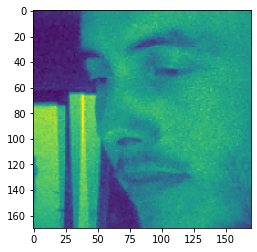

In [10]:
pyplot.imshow(np.array(df.pixelValues.loc[0].split(" ")).reshape(170,170).astype("float"))

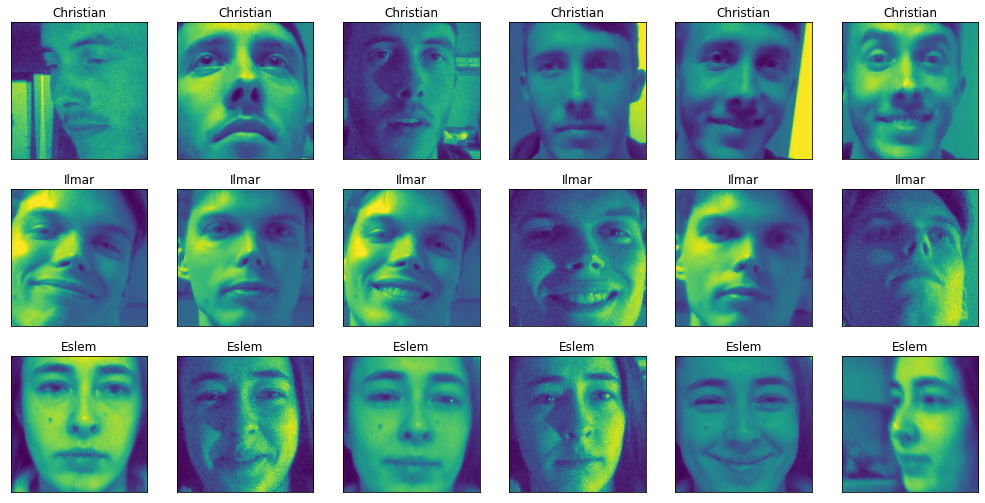

In [11]:
fig = pyplot.figure(1, (14, 14))
k = 0
px = None
for label in sorted(df.nameNumber.unique()):
    for j in range(6):
        px = df[df.nameNumber==label].pixelValues.iloc[k]
        px = np.array(px.split(' ')).reshape(170, 170).astype('float32')
        k += 1
        ax = pyplot.subplot(6, 6, k)
        ax.imshow(px)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[label])
        pyplot.tight_layout()

In [12]:
print (df.pixelValues)
img_array = df.pixelValues.apply(lambda x : np.array(x.split(" ")).reshape(170,170,1).astype("float32"))


0      37 35 35 33 33 39 45 45 38 43 45 41 37 35 35 3...
1      80 84 84 84 87 88 88 97 103 112 120 122 124 12...
2      75 64 63 52 53 53 50 57 68 105 123 140 152 160...
3      74 73 73 73 73 73 74 74 75 74 74 74 75 74 74 7...
4      99 92 82 69 62 59 52 47 31 26 21 19 17 16 16 1...
                             ...                        
208    18 21 22 23 26 37 33 29 30 29 29 30 30 30 32 3...
209    94 91 89 88 86 83 78 75 76 71 67 66 67 67 67 6...
210    7 8 10 4 12 11 19 17 14 14 11 14 11 9 19 23 22...
211    98 99 99 97 96 96 96 96 94 82 45 38 41 48 54 6...
212    16 19 16 14 19 23 23 25 25 26 27 29 27 26 29 2...
Name: pixelValues, Length: 213, dtype: object


In [13]:
img_array = np.stack(img_array,axis=0)

In [14]:
img_array.shape

(213, 170, 170, 1)

In [15]:
labels = df.nameNumber.values

In [16]:
X_train,X_test,y_train,y_test = train_test_split(img_array,labels,test_size=.2)

In [17]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((170, 170, 170, 1), (170,), (43, 170, 170, 1), (43,))

In [18]:
X_train = X_train/255
X_test = X_test/255

In [19]:
basemodel = tf.keras.models.Sequential([tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape = (170,170,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        #
                                        tf.keras.layers.Conv2D(64,(3,3),activation='relu',input_shape = (170,170,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        #
                                        tf.keras.layers.Conv2D(128,(3,3),activation='relu',input_shape = (170,170,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        #
                                        tf.keras.layers.Conv2D(256,(3,3),activation='relu',input_shape= (170,170,1)),
                                        tf.keras.layers.MaxPool2D(2,2),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(1000,activation='relu'),
                                        tf.keras.layers.Dense(3,activation = 'softmax')                          
                                        ])

2021-12-30 03:46:50.962273: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-30 03:46:50.964275: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [20]:
basemodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 168, 168, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 84, 84, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 82, 82, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 41, 41, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 39, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 19, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 256)       2

In [21]:
basemodel.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=.0001),
                loss = "sparse_categorical_crossentropy",
                metrics = ["accuracy"])


In [22]:
import os
try:
    os.mkdir("checkpoint")
except:
    pass


In [23]:
file_name = 'best_model.h5'
checkpoint_path = "checkpoint"

call_back = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                 monitor='val_accuracy', 
                                                 verbose=1,
                                                 save_freq='epoch',
                                                 save_best_only=True, 
                                                 save_weights_only=False, 
                                                 mode='max')

In [24]:
basemodel.fit(X_train,y_train,epochs=50,validation_split=.2,callbacks=[call_back])

Train on 136 samples, validate on 34 samples
Epoch 1/50
128/136 [===========================>..] - ETA: 0s - loss: 1.0860 - accuracy: 0.4141
Epoch 00001: val_accuracy improved from -inf to 0.82353, saving model to checkpoint
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


2021-12-30 03:46:59.497775: W tensorflow/python/util/util.cc:299] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: checkpoint/assets
136/136 [==============================] - 9s 69ms/sample - loss: 1.0872 - accuracy: 0.4118 - val_loss: 1.0378 - val_accuracy: 0.8235
Epoch 2/50
128/136 [===========================>..] - ETA: 0s - loss: 1.0086 - accuracy: 0.7031
Epoch 00002: val_accuracy did not improve from 0.82353
136/136 [==============================] - 5s 33ms/sample - loss: 1.0054 - accuracy: 0.6912 - val_loss: 0.9409 - val_accuracy: 0.5294
Epoch 3/50
128/136 [===========================>..] - ETA: 0s - loss: 0.9125 - accuracy: 0.5938
Epoch 00003: val_accuracy improved from 0.82353 to 0.85294, saving model to checkpoint
INFO:tensorflow:Assets written to: checkpoint/assets
136/136 [==============================] - 5s 40ms/sample - loss: 0.9177 - accuracy: 0.5956 - val_loss: 0.7798 - val_accuracy: 0.8529
Epoch 4/50
128/136 [===========================>..] - ETA: 0s - loss: 0.8087 - accuracy: 0.7422
Epoch 00004: val_accuracy did not improve from 0.85294
136/136

Actual person:  Ilmar
Predicted person:  Ilmar


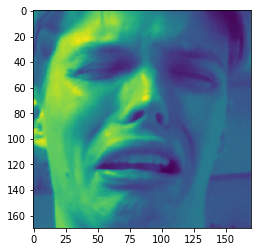

In [27]:
final_model = tf.keras.models.load_model(checkpoint_path)

from IPython.display import clear_output
import time
for k in range(40):
    print(f'Actual person:  {label_to_text[y_test[k]]}')
    predicted_class = final_model.predict(tf.expand_dims(X_test[k],0)).argmax()
    print(f'Predicted person:  {label_to_text[predicted_class]}')
    pyplot.imshow(X_test[k])
    pyplot.show()
    time.sleep(3)
    clear_output(wait=True)